# Example of registering cortical z-stack.
- Compared to the previous version in brain_observatory_qc, the updated version implemenets picking the best inter-correlated frames from a plane, which greatly increases the quality of within-plane registration.
    - Particularly for RiboL1-GCaMP.
- depth_estimation_module updated on 02/13/2024

In [1]:
import numpy as np
import brain_observatory_qc.pipeline_dev.scripts.depth_estimation_module as dem
from tifffile import imread, imsave
from pathlib import Path
import scipy
import skimage
import matplotlib.pyplot as plt
import io
import imageio
import cv2

In [2]:
# zstack_dir = Path(r'\\allen\programs\braintv\workgroups\ophysdev\OPhysCore\operator_files\vivian_ha\717487')
# zstack_fn = zstack_dir / '20240209_717487_corticalstack_V1_real_00001.tif'

zstack_dir = Path(r'\\allen\programs\mindscope\production\u01bfct\prod0\specimen_1321880482')
zstack_fn = zstack_dir / '1329386702_cortical_z_stack0.tiff'

In [3]:
def read_si_stack_metadata(zstack_fn):
    '''Reads metadata from a ScanImage z-stack tiff file.
    
    Args:
        zstack_fn: str or Path, path to the z-stack tiff file
        
    Returns:
        num_slices: int, number of slices in the z-stack
        num_volumes: int, number of volumes in the z-stack
        actuator: str, the actuator used to move the z-stack
        z_values: np.array, the z values of each slice in the z-stack

    TODO: check if actuator and z-values are correct
    '''
    from PIL import Image
    from PIL.TiffTags import TAGS
    with Image.open(zstack_fn) as img:
        meta_dict = {TAGS[key] : img.tag[key] for key in img.tag_v2}
    
    num_slices_ind = np.where(['SI.hStackManager.numSlices = ' in x for x in meta_dict['Software'][0].split('\n')])[0][0]
    num_slices_txt = meta_dict['Software'][0].split('\n')[num_slices_ind]
    num_slices = int(num_slices_txt.split('= ')[1])
    
    num_volumes_ind = np.where(['SI.hStackManager.numVolumes = ' in x for x in meta_dict['Software'][0].split('\n')])[0][0]
    num_volumes_txt = meta_dict['Software'][0].split('\n')[num_volumes_ind]
    num_volumes = int(num_volumes_txt.split('= ')[1])

    actuator_ind = np.where(['SI.hStackManager.stackActuator = ' in x for x in meta_dict['Software'][0].split('\n')])[0][0]
    actuator_txt = meta_dict['Software'][0].split('\n')[actuator_ind]
    actuator = actuator_txt.split('= ')[1].split('\'')[1]

    zs_ind = np.where(['SI.hStackManager.zs = ' in x for x in meta_dict['Software'][0].split('\n')])[0][0]
    zs = meta_dict['Software'][0].split('\n')[zs_ind]
    z_values = np.array([float(z) for z in zs.split('[')[1].split(']')[0].split(' ')])

    return num_slices, num_volumes, actuator, z_values


def average_reg_plane(images):
    """Get mean FOV of a plane after registration.
    Use phase correlation

    Parameters
    ----------
    images : np.ndarray (3D)
        frames from a plane

    Returns
    -------
    np.ndarray (2D)
        mean FOV of a plane after registration.
    """
    # ref_img = np.mean(images, axis=0)
    ref_img, _ = pick_initial_reference(images)
    reg = np.zeros_like(images)
    for i in range(images.shape[0]):
        shift, _, _ = skimage.registration.phase_cross_correlation(
            ref_img, images[i, :, :], normalization=None)
        reg[i, :, :] = scipy.ndimage.shift(images[i, :, :], shift)
    return np.mean(reg, axis=0)


def pick_initial_reference(frames: np.ndarray, num_for_ref: int = 20) -> np.ndarray:
    """ computes the initial reference image

    the seed frame is the frame with the largest correlations with other frames;
    the average of the seed frame with its top 20 correlated pairs is the
    inital reference frame returned

    From suite2p.registration.register

    Parameters
    ----------
    frames : 3D array, int16
        size [frames x Ly x Lx], frames from binary

    Returns
    -------
    refImg : 2D array, int16
        size [Ly x Lx], initial reference image

    """
    nimg,Ly,Lx = frames.shape
    frames = np.reshape(frames, (nimg,-1)).astype('float32')
    frames = frames - np.reshape(frames.mean(axis=1), (nimg, 1))
    cc = np.matmul(frames, frames.T)
    ndiag = np.sqrt(np.diag(cc))
    cc = cc / np.outer(ndiag, ndiag)
    CCsort = -np.sort(-cc, axis = 1)
    bestCC = np.mean(CCsort[:, 1:num_for_ref], axis=1)
    imax = np.argmax(bestCC)
    indsort = np.argsort(-cc[imax, :])
    selected_frame_inds = indsort[0:num_for_ref]
    refImg = np.mean(frames[selected_frame_inds, :], axis = 0)
    refImg = np.reshape(refImg, (Ly,Lx))
    return refImg, selected_frame_inds


def reg_between_planes(stack_imgs, ref_ind=30, top_ring_buffer=10, window_size=1, use_adapthisteq=True):
    """Register between planes. Each plane with single 2D image
    Use phase correlation.
    Use median filtered images to calculate shift between neighboring planes.
    Resulting image is not filtered.

    Parameters
    ----------
    stack_imgs : np.ndarray (3D)
        images of a stack. Typically z-stack with each plane registered and averaged.
    ref_ind : int, optional
        index of the reference plane, by default 30
    top_ring_buffer : int, optional
        number of top lines to skip due to ringing noise, by default 10
    window_size : int, optional
        window size for rolling, by default 4
    use_adapthisteq : bool, optional
        whether to use adaptive histogram equalization, by default True

    Returns
    -------
    np.ndarray (3D)
        Stack after plane-to-plane registration.
    """
    num_planes = stack_imgs.shape[0]
    reg_stack_imgs = np.zeros_like(stack_imgs)
    reg_stack_imgs[ref_ind, :, :] = stack_imgs[ref_ind, :, :]
    ref_stack_imgs = med_filt_z_stack(stack_imgs)
    if use_adapthisteq:
        for i in range(num_planes):
            plane_img = ref_stack_imgs[i, :, :]
            ref_stack_imgs[i, :, :] = image_normalization_uint16(skimage.exposure.equalize_adapthist(
                plane_img.astype(np.uint16)))  # normalization to make it uint16

    temp_stack_imgs = np.zeros_like(stack_imgs)

    temp_stack_imgs[ref_ind, :, :] = ref_stack_imgs[ref_ind, :, :]
    for i in range(ref_ind + 1, num_planes):
        # Calculation valid pixels
        temp_ref = np.mean(
            temp_stack_imgs[max(0, i - window_size) : i, :, :], axis=0)
        temp_mov = ref_stack_imgs[i, :, :]
        valid_y, valid_x = calculate_valid_pix(temp_ref, temp_mov)

        temp_ref = temp_ref[valid_y[0] +
                            top_ring_buffer:valid_y[1] + 1, valid_x[0]:valid_x[1] + 1]
        temp_mov = temp_mov[valid_y[0] +
                            top_ring_buffer:valid_y[1] + 1, valid_x[0]:valid_x[1] + 1]

        shift, _, _ = skimage.registration.phase_cross_correlation(
            temp_ref, temp_mov, normalization=None, upsample_factor=10)
        temp_stack_imgs[i, :, :] = scipy.ndimage.shift(
            ref_stack_imgs[i, :, :], shift)
        reg_stack_imgs[i, :, :] = scipy.ndimage.shift(
            stack_imgs[i, :, :], shift)
    if ref_ind > 0:
        for i in range(ref_ind - 1, -1, -1):
            temp_ref = np.mean(
                temp_stack_imgs[i+1 : min(num_planes, i + window_size + 1), :, :], axis=0)
            temp_mov = ref_stack_imgs[i, :, :]
            valid_y, valid_x = calculate_valid_pix(temp_ref, temp_mov)

            temp_ref = temp_ref[valid_y[0] +
                                top_ring_buffer:valid_y[1] + 1, valid_x[0]:valid_x[1] + 1]
            temp_mov = temp_mov[valid_y[0] +
                                top_ring_buffer:valid_y[1] + 1, valid_x[0]:valid_x[1] + 1]

            shift, _, _ = skimage.registration.phase_cross_correlation(
                temp_ref, temp_mov, normalization=None, upsample_factor=10)
            temp_stack_imgs[i, :, :] = scipy.ndimage.shift(
                ref_stack_imgs[i, :, :], shift)
            reg_stack_imgs[i, :, :] = scipy.ndimage.shift(
                stack_imgs[i, :, :], shift)
    return reg_stack_imgs


def calculate_valid_pix(img1, img2, valid_pix_threshold=1e-3):
    """Calculate valid pixels for registration between two images
    There can be blank pixels at the edge of the image.
    Parameters
    ----------
    img1 : np.ndarray (2D)
        Image 1
    img2 : np.ndarray (2D)
        Image 2
    valid_pix_threshold : float, optional
        threshold for valid pixels, by default 1e-3

    Returns
    -------
    list
        valid y range
    list
        valid x range
    """
    y1, x1 = np.where(img1 > valid_pix_threshold)
    y2, x2 = np.where(img2 > valid_pix_threshold)
    # unravel the indices
    valid_y = [max(min(y1), min(y2)), min(max(y1), max(y2))]
    valid_x = [max(min(x1), min(x2)), min(max(x1), max(x2))]
    return valid_y, valid_x


def med_filt_z_stack(zstack, kernel_size=5):
    """Get z-stack with each plane median-filtered

    Parameters
    ----------
    zstack : np.ndarray
        z-stack to apply median filtering
    kernel_size : int, optional
        kernel size for median filtering, by default 5
        It seems only certain odd numbers work, e.g., 3, 5, 11, ...

    Returns
    -------
    np.ndarray
        median-filtered z-stack
    """
    filtered_z_stack = []
    for image in zstack:
        filtered_z_stack.append(cv2.medianBlur(
            image.astype(np.uint16), kernel_size))
    return np.array(filtered_z_stack)


def image_normalization_uint16(image, im_thresh=0):
    """Normalize 2D image and convert to uint16
    Prevent saturation.

    Args:
        image (np.ndarray): input image (2D)
                            Just works with 3D data as well.
        im_thresh (float, optional): threshold when calculating pixel intensity percentile.
                            0 by default
    Return:
        norm_image (np.ndarray)
    """
    clip_image = np.clip(image, np.percentile(
        image[image > im_thresh], 0.2), np.percentile(image[image > im_thresh], 99.8))
    norm_image = (clip_image - np.amin(clip_image)) / \
        (np.amax(clip_image) - np.amin(clip_image)) * 0.9
    uint16_image = ((norm_image + 0.05) *
                    np.iinfo(np.uint16).max * 0.9).astype(np.uint16)
    return uint16_image

In [4]:
num_slices, num_volumes, actuator, z_values = read_si_stack_metadata(zstack_fn)

In [5]:
# Takes about 5 min
zstack = imread(zstack_fn)
# it takes > 1 min to get n_frames from PIL (for 42000 frames)
# No num pages from tiff metadata
# opening tiff using cv2 does not make it faster

In [6]:
# 44 min for 420 slices

plane_reg_imgs = np.zeros((num_slices, zstack.shape[1], zstack.shape[2]))
for plane_ind in range(num_slices):
    temp_imgs = zstack[plane_ind::num_slices]
    reg_img = average_reg_plane(temp_imgs)
    plane_reg_imgs[plane_ind] = reg_img


In [7]:
# 2 min for 420 slices
between_plane_reg_imgs = reg_between_planes(np.array(plane_reg_imgs), ref_ind=50)

In [9]:
save_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\pilots\online motion correction')
save_fn = save_dir / (zstack_fn.stem + '_between_plane_registered.tif')
imsave(save_fn, between_plane_reg_imgs)

C:\Users\jinho.kim\AppData\Local\Temp\ipykernel_20008\3338245261.py:3: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave(save_fn, between_plane_reg_imgs)


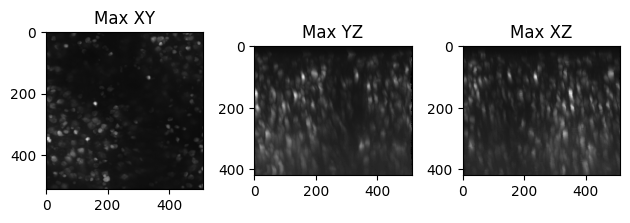

In [12]:
fig, ax = plt.subplots(1,3)
projection_names = ['Max XY', 'Max YZ', 'Max XZ']
for i in range(3):
    ax[i].imshow(np.max(between_plane_reg_imgs, axis=i), cmap='gray')
    ax[i].set_title(projection_names[i])
fig.tight_layout()

In [13]:
top_depth = 20
zstep_um = 1
spatial_resolution_um = 0.78

vmin = np.percentile(np.array(plane_reg_imgs), 0.1)
vmax = np.percentile(np.array(plane_reg_imgs), 99.9)
annotated_images = []
for i, image in enumerate(between_plane_reg_imgs):
    fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
    ax.imshow(image, cmap='gray', vmin=vmin, vmax=vmax)
    scale_bar_length_px = int(100 / spatial_resolution_um)

    # Draw the scale bar on the bottom right corner of the image
    scale_bar_x = image.shape[1] - scale_bar_length_px - 10
    scale_bar_y = image.shape[0] - 20
    scale_bar_end_x = image.shape[1] - 10
    scale_bar_end_y = image.shape[0] - 20
    ax.plot([scale_bar_x, scale_bar_end_x], [scale_bar_y, scale_bar_end_y], color='white', linewidth=2)

    # Add the scale bar text
    scale_bar_text = '100 μm'
    ax.text(scale_bar_x + scale_bar_length_px/2, scale_bar_y - 10, scale_bar_text, color='white', fontsize=10, 
        horizontalalignment='center')

    # Add the depth text
    depth_text = f'{top_depth - i * zstep_um} μm'
    ax.text(500, 30, depth_text, color='white', fontsize=15,
        horizontalalignment='right')

    ax.axis('off')
    fig.tight_layout(pad=0)

    # convert the figure content to a numpy array
    io_buf = io.BytesIO()
    fig.savefig(io_buf, format='raw', dpi=100)
    io_buf.seek(0)
    img_arr = np.reshape(np.frombuffer(io_buf.getvalue(), dtype=np.uint8),
                        newshape=(int(fig.bbox.bounds[3]), int(fig.bbox.bounds[2]), -1))
    io_buf.close()

    # Append the annotated image to the list and close the figure
    annotated_images.append(img_arr[:,:,0])
    plt.close(fig)


# Saving the results
- tiff and gif

In [15]:
imageio.mimwrite(save_dir / (zstack_fn.stem + '_annotated_zstack.tif'), annotated_images)
imageio.mimsave(save_dir / (zstack_fn.stem + '_annotated_zstack.gif'), annotated_images, duration=50)